## Importing Packages

In [1]:
!pip install tldextract > /dev/null

The system cannot find the path specified.


In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from keras.models import  Sequential
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from urllib.parse import urlparse
import re
import tldextract
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\sid321axn\malicious-urls-dataset\versions\1


In [5]:
try : 
  data = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')
except :
  data = pd.read_csv(f"{path}\malicious_phish.csv")

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\OMEN\AppData\Local\Temp\ipykernel_6436\475881228.py:4: SyntaxWarning: invalid escape sequence '\m'
  data = pd.read_csv(f"{path}\malicious_phish.csv")


In [6]:
data.sample(5)

,url,type
214897,http://shantasells.com/blog/for-buyers.1,defacement
117065,bukisa.com/topics/roman-catholic-church-in-quebec,benign
551684,http://164.68.127.176/beastmode/b3astmode.ppc,malware
83598,askheritage.com/,benign
97299,stlzoo.org/events/calendarofevents/spookysaturday,benign


In [ ]:
# phishing using URLs, attackers create fake websites (that look like legitimate ones) to collect sensitive information
# defacement : URL Redirects , Subdomain or URL Path Hijacking ,
# Injecting Malicious Content:   Attackers might manipulate URLs or inject malicious code (such as JavaScript) through URL parameters. This can cause the targeted webpage to display altered or harmful content to the user
# Defacement through URL Spoofing: An attacker may create a fake URL that looks like the legitimate website’s URL. The attacker may modify the page associated with that URL to display their own content, similar to how a website defacement works.

In [7]:
data.shape

(651191, 2)

## Data visualisation 📈

In [8]:
type_counts = data['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

fig = px.bar(
    type_counts,
    x='type',
    y='count',
    title='Type Distribution',
    labels={'type': 'Type', 'count': 'Count'},
    color='type',
    color_discrete_map={
        'benign': 'green',
        'phishing': 'orange',
        'defacement': 'brown',
        'malware': 'red'
    }
)
fig.show()

In [ ]:
data.shape[0]

651191

## Label Encoding

In [ ]:
label_mapping = {"benign": 0, "phishing": 1, "defacement": 2, "malware" : 3}
data['label'] = data['type'].map(label_mapping)

In [ ]:
data['label']

,label
0,1
1,0
2,0
3,2
4,2
...,...
651186,1
651187,1
651188,1
651189,1


In [ ]:
common_keywords = np.loadtxt('common_keywords.txt', dtype=str).tolist()
print(common_keywords)


['login', 'admin', 'download', 'upload', 'register', 'profile', 'search', 'checkout', 'cart', 'html', 'php', 'jpg', 'css', 'png', 'js', 'min', 'exe', 'purchase', 'order', 'payment', 'contact', 'about', 'contactus', 'product', 'news', 'blog', 'article', 'faq', 'support', 'subscribe', 'unsubscribe', 'newsletter', 'terms', 'privacy', 'policy', 'cookie', 'error', '404', '403', '500', 'confirm', 'verify', 'reset', 'password', 'confirmation', 'notification', 'account', 'user', 'signup', 'signin', 'logout', 'feedback', 'feedbackform', 'feedbacksurvey', 'survey', 'rating', 'review', 'comment', 'contactinfo', 'contactdetails', 'contactform', 'contactusform', 'contactinfo', 'contactinformation', 'contactusinfo', 'contactusinformation', 'contactusdetails', 'contactuspage', 'contactuscontact', 'contactuscontactinfo', 'contactuscontactinformation', 'contactuscontactdetails', 'contactuscontactus', 'contactuscontactusinfo', 'contactuscontactusinformation', 'contactuscontactusdetails', 'contactusconta

In [ ]:
def extract_url_features(url, words_list):
    parsed_url = urlparse(url)

    # Domain Features
    domain = parsed_url.netloc
    domain_length = len(domain)
    num_subdomains = domain.count('.')
    has_hyphen = '-' in domain

    # Path Features
    path = parsed_url.path
    path_length = len(path)
    num_path_segments = path.count('/')

    # Top-Level Domain (TLD) Features
    tld_info = tldextract.extract(domain)
    tld = tld_info.suffix
    tld_length = len(tld)
    subdomain = tld_info.subdomain

    # Protocol Features
    protocol = parsed_url.scheme
    is_https = protocol == 'https'

    # Query Parameters Features
    query_params = parsed_url.query
    num_query_params = len(query_params.split('&'))

    char_features = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-_.~!*'()$&+,;=:/?#@[]{}|\\^")
    char_frequencies = {char: url.lower().count(char) for char in char_features}


    keyword_counts = {keyword: url.lower().count(keyword) for keyword in words_list}

    url_length = len(url)

    has_redirect = '->' in url
    has_shortened_url = re.search(r'bit\.ly|t\.co|ow\.ly', url) is not None


    feature_array = [
        domain_length, num_subdomains, int(has_hyphen),
        path_length, num_path_segments, tld_length,
        int(is_https), num_query_params, url_length,
        int(has_redirect), int(has_shortened_url)
    ]

    # Add character frequencies as features in a fixed order
    feature_array.extend([char_frequencies[char] for char in char_features])

    # Add keyword counts as features in a fixed order
    feature_array.extend([keyword_counts[keyword] for keyword in words_list])

    return feature_array

dataWithFeatures = []

for index, row in data.iterrows():
    newRow = []
    url = row['url']
    label = row['label']

    features = extract_url_features(url, common_keywords)


    for feature in features:
        newRow.append(feature)

    newRow.append(label)

    dataWithFeatures.append(newRow)

data = pd.DataFrame(dataWithFeatures)

In [ ]:
x = data.iloc[:, 0: -1 ]
y = data.iloc[:, -1]

x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.20, random_state=42 , stratify=y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.20, random_state=42 , stratify=y_val_test)

In [ ]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
x_val = pd.DataFrame(x_val)
y_val = pd.DataFrame(y_val)

## Handling Imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy= {3: 100000} , random_state=42 )

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# under = RandomUnderSampler(sampling_strategy={0: 150000} , random_state=42)

In [ ]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('oversample', smote )
   # ('undersample', under )
])

x_train , y_train = pipeline.fit_resample(x_train, y_train)

In [ ]:
y_train.value_counts()

,count
184,
0,342482
3,100000
2,77165
1,75289


## Normalising our data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


# ML Tree Ensemble Model

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=42, verbose=1 , class_weight='balanced', n_jobs=-1)

clf.fit(x_train, np.array(y_train).reshape( -1, ) )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.5s finished


ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                     verbose=1)

In [ ]:
y_pred = clf.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


Accuracy: 0.97


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
def model_evalutation( y_pred , model_name ) :

  labels = list(label_mapping.keys())
  cm = confusion_matrix(y_test, y_pred  )

  plt.figure(figsize=(10,8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()


  report = classification_report( y_test , y_pred,  target_names=labels , output_dict = True )
  df_report = pd.DataFrame(report).transpose()

  df_plot = df_report.drop(columns=['support'], errors='ignore')

  plt.figure(figsize=(10, 6))
  sns.heatmap(df_plot, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
  plt.title(f'Classification Report {model_name}', fontsize=14)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)

  plt.tight_layout()
  plt.show()


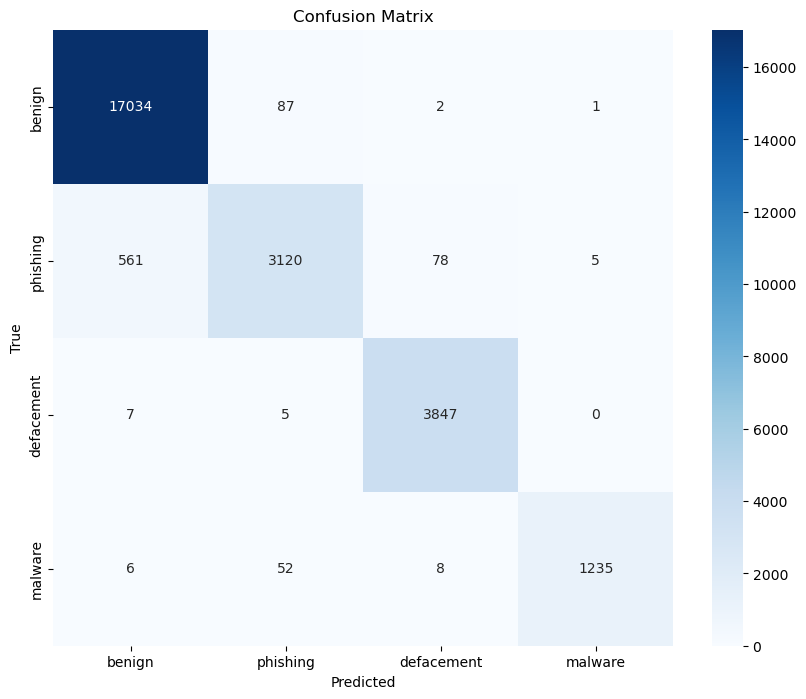

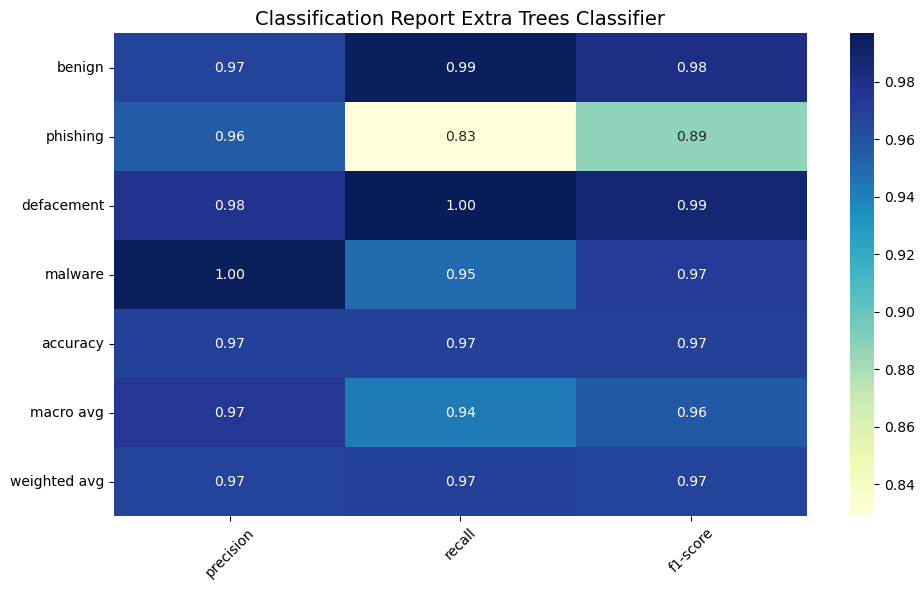

In [ ]:
model_evalutation( y_pred , 'Extra Trees Classifier' )

# Swarm Optimisation (Metaheuristic)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    n_estimators = max(10, n_estimators)
    max_depth = max(1, max_depth)
    min_samples_split = max(2, min_samples_split)

    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        verbose=0
    )

    model.fit(x_train, np.ravel(y_train))
    val_preds = model.predict(x_val)
    acc = accuracy_score(np.ravel(y_val), val_preds)

    return -acc

In [ ]:
from pyswarms.single.global_best import GlobalBestPSO

bounds = ([10, 2, 2], [100, 30, 20])  # n_estimators, max_depth, min_samples_split
optimizer = GlobalBestPSO(n_particles=10, dimensions=3, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)

best_cost, best_params = optimizer.optimize(lambda x: np.array([objective_function(p) for p in x]), iters=20)

print("Best Accuracy:", -best_cost)
print("Best Params:", best_params)

Best Accuracy: 0.9553896209845381

Best Params: [66.0836693  29.31785261  5.62044184]

In [ ]:
best_params =  [66.0836693, 29.31785261, 5.62044184]

best_n_estimators = int(best_params[0])
best_max_depth = int(best_params[1])
best_min_samples_split = int(best_params[2])

clf = ExtraTreesClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

clf.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  2.5min finished


ExtraTreesClassifier(class_weight='balanced', max_depth=29, min_samples_split=5,
                     n_estimators=66, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Accuracy: 0.95


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  66 out of  66 | elapsed:    0.5s finished


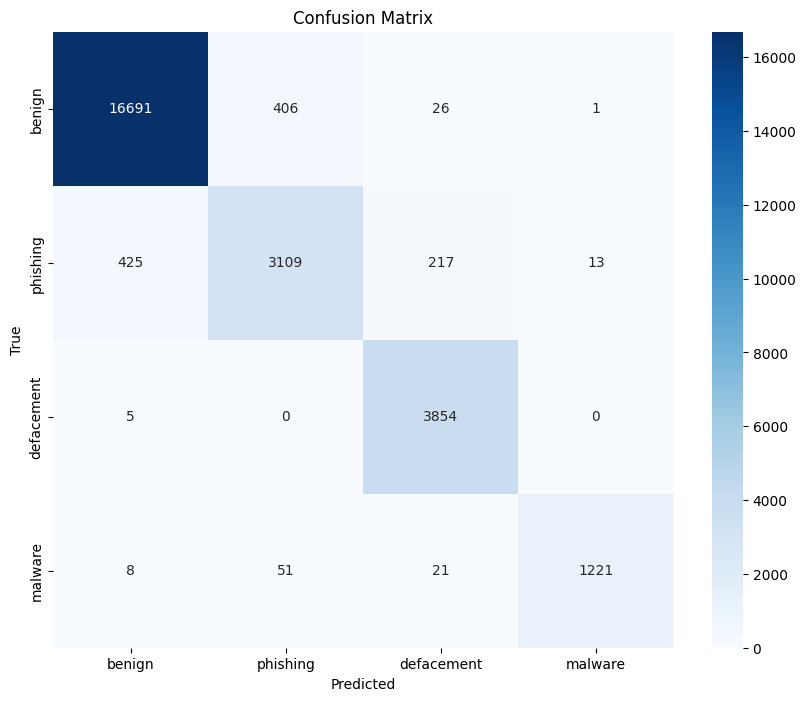

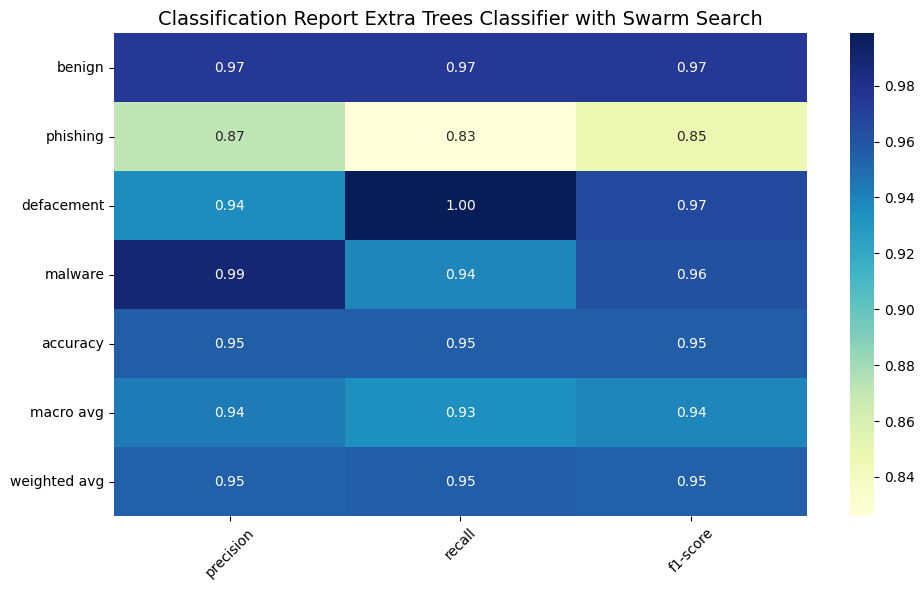

In [ ]:
model_evalutation( y_pred , 'Extra Trees Classifier with Swarm Search' )

# DL Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

def create_model(input_shape, num_classes):
    model = Sequential([

        Dense(512, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy' , tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

from tensorflow.keras.utils import to_categorical

y_train_one = to_categorical(y_train, num_classes=4)
y_test_one = to_categorical(y_test, num_classes=4)
y_val_one = to_categorical(y_val, num_classes=4)

model = create_model(x_train.shape[1], y_train_one.shape[1])
model.summary()

c:\Users\OMEN\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │        94,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,300 (1.03 MB)

 Trainable params: 269,380 (1.03 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max' , patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', mode='max' , factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]


classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y= y_train.values.ravel() )
class_weight_dict = dict(zip(classes, class_weights))


history = model.fit(
    x_train, y_train_one ,
    validation_data=(x_val, y_val_one),
    epochs=100,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8282 - loss: 1.0653 - precision_3: 0.8582 - recall_3: 0.7967 - val_accuracy: 0.9487 - val_loss: 0.2996 - val_precision_3: 0.9520 - val_recall_3: 0.9450 - learning_rate: 0.0010
Epoch 2/100
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9337 - loss: 0.3129 - precision_3: 0.9379 - recall_3: 0.9298 - val_accuracy: 0.9521 - val_loss: 0.2344 - val_precision_3: 0.9546 - val_recall_3: 0.9498 - learning_rate: 0.0010
Epoch 3/100
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9406 - loss: 0.2653 - precision_3: 0.9439 - recall_3: 0.9374 - val_accuracy: 0.9534 - val_loss: 0.2248 - val_precision_3: 0.9553 - val_recall_3: 0.9515 - learning_rate: 0.0010
Epoch 4/100
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9441 - loss: 0.2548 - precision_3: 0.9473 - recall_3: 0.9413 - val_accuracy: 0.9541 - val_loss: 0.2240 - val_precision_3: 0.9553 - val_recall_3: 0.9528 - learning_rate: 0.0010
Epoch 5/100


In [ ]:

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)


accuracy = accuracy_score( np.argmax( y_test_one , axis=1) , y_pred)
print(f'Accuracy: {accuracy:.2f}')

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.97


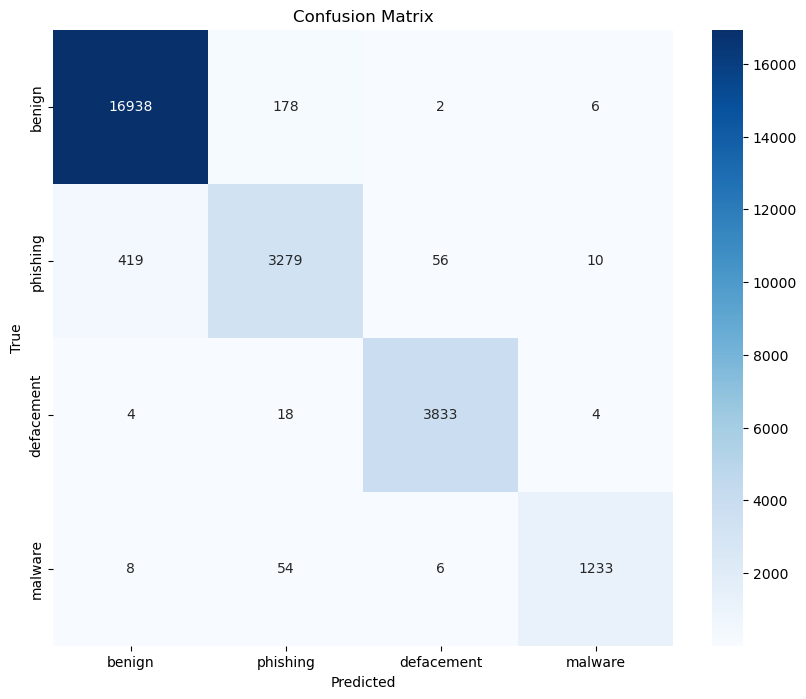

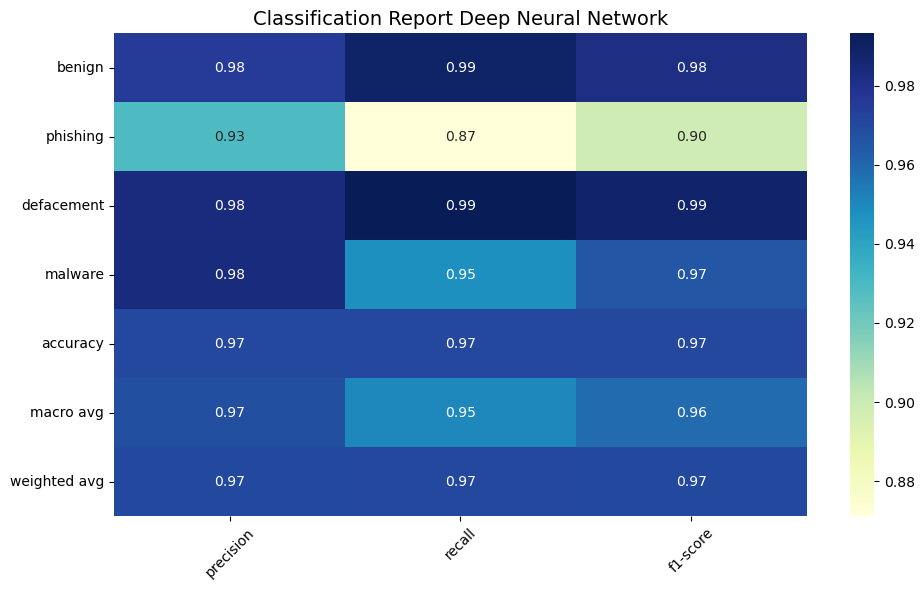

In [ ]:
model_evalutation( y_pred , 'Deep Neural Network' )

## Exporting the best Model

In [ ]:
import joblib
joblib.dump(model, r'url-classifier\backend\Model\model.pkl')

['url-classifier\\backend\\Model\\model.pkl']

In [ ]:
joblib.dump(scaler, r'url-classifier\backend\Model\scaler.pkl')

['url-classifier\\backend\\Model\\scaler.pkl']

## Importing the best Model

In [ ]:
import joblib
model = joblib.load(r'url-classifier\backend\Model\model.pkl')

## Classifying a Random URL

In [ ]:
idx2Label = {0: "benign", 1: "phishing", 2: "defacement", 3: "malware"}

In [ ]:
def predict_url_class(url, model = model ):

    features = extract_url_features(url, common_keywords)

    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)

    y_pred_idx = model.predict(features)
    y_pred_idx = np.argmax(y_pred_idx, axis=1)[0]

    y_pred = idx2Label.get(y_pred_idx, y_pred_idx)

    return y_pred

predict_url_class("travel.yahoo.com/p-travelguide-2803882-insecta")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


'benign'

In [ ]:
predict_url_class("www.facebook.net")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'benign'